# Проверка влияния фестивалей на продажу авиабилетов

## Цель проекта: 
Проверить гипотезу:
> «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».

# 0. Общая информация

Импортируем библиотеки, откроем файлы, посмотрим на них и отправимся в сторону аналитики.

Сперва - библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np

Теперь сами файлы.

In [2]:
query_1 = pd.read_csv('/datasets/query_1.csv')
query_1

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [3]:
query_3 = pd.read_csv('/datasets/query_3.csv')
query_3

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


На первый взгляд (не вдаваясь в аналитику или даже раздел "info") данные в порядке. Разбираться с "наглядными аномалиями" будем дальше. Время аналитики.

# 1. Анализ данных

К моему удивлению (хотя, чему я собственно удивляюсь? Я же вижу эти данные впервые) данных в первых 3 выборках крайне мало. И выглядит это скорее как задача аналитика, нежели дата саентиста. Но всё это - основанные ни на чем представления. Поэтому, пока я в этом разбираюсь недостаточно, логика такова - дали задание, делай. В процессе может быть поймешь, почему его стоит (или не стоит) делать и как это лучше сделать.

Выборка №1 - с моделями самолетов и числом полетов. \
8 строк, 8 моделей самолетов.

Проверим типы данных на корректность.

In [4]:
query_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


Модель - "обджект", количество полетов - "целочисленный". Да, нас такой вариант переменных вполне устраивает. Не может же у вас быть половины или трети полета - это тогда будет фильм-катастрофа или какие-нибудь "новости". \

Построим гистограмму зависимости количества рейсов от модели самолета. 

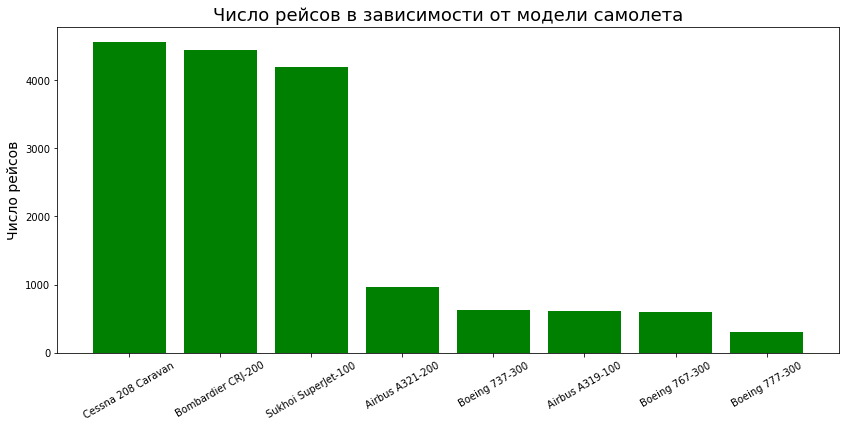

In [5]:
query_1 = query_1.sort_values(by = 'flights_amount', ascending = False)

plt.figure(figsize = (14,6))
plt.bar(query_1['model'], query_1['flights_amount'], color = 'green')
plt.xticks(rotation=30, fontsize = '10')
plt.ylabel('Число рейсов', fontsize = '14')
plt.title('Число рейсов в зависимости от модели самолета', fontsize = '18')
plt.show()

Единственное "противоречивое" и не до конца объяснимое - это существенное расхождение в количестве рейсов для 3 моделей (суперджет, бомбрадье, цесна) по отношению к остальным 5 моделям самолетов. \
Наиболее вероятная логика такого распределения скрывается в типах самолетов. 2 из них - для локальных (КОРОТКИХ) перелетов - Цесна и Бомбардье, остальные для более дальних. При этом, если делить все имеющиеся перелеты по типам дальности самолетов, получится примерно поровну - половина от всего объема на Цесну и Бомбардье, половина на все остальные.

Следовательно, такое распределение по "возможное длине перелёта" (напрямую зависящей от технических характеристик самолета) - прекрасный указатель на то, что мы наблюдаем в России много лет к ряду. Да, много "ДЛИННЫХ" рейсов, но столько же и "КОРОТКИХ" рейсов. Вероятно, это обусловлено тем, что плотность перелётов (наверняка есть подобный термин) куда выше в европейской части страны, в то время как плотность "над Уралом и восточнее" - по крайней мере ВНУТРИ страны - существенно ниже. Наверняка, отражение этой истории мы увидим при анализе среднего числа перелетов в зависимости от города.

Перейдем к выборке №3. Здесь у нас города и осредненное ежедневное число рейсов В (это важно!) эти города.

In [6]:
query_3.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


In [7]:
query_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


Типы нас по-прежнему устраивают. Да, появляются "дробные полеты", однако, в случае средних значения (для нашей задачи сравнения) такой вариант вполне подходит. Единственное, можно было бы выбрать тип переменной занимающий меньший объем памяти, т.к. чисто физически аэропорты городов (а их максимум 7 - в Нью-Йорке и Ванкувере) не смогут обслуживать ОГРОМНОЕ число самолетов и рейсов. Следовательно, это значение вполне может быть ограничено значением в 10 000 рейсов в сутки. А значит можно взять "меньший" по памяти тип переменных. 

Найдем ТОП-10 городов с наибольшим числом рейсов.

In [8]:
city_top_10_flights = query_3.sort_values(by = 'average_flights', ascending = False).head(10)
city_top_10_flights

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


Очевидные Москва и Петербург на 1 и 2 месте. Достаточно очевидыне миллионники на 3-8 местах. Солнечный и от того не менее очевидный Сочи на 9 месте. И крайне неожиданный Ульяновск. \
Эту логику распределения мы уже частично увидели в первой выборке - по моделям самолетов.

Сегодня наш ТОП получился таким, но что будет завтра?!

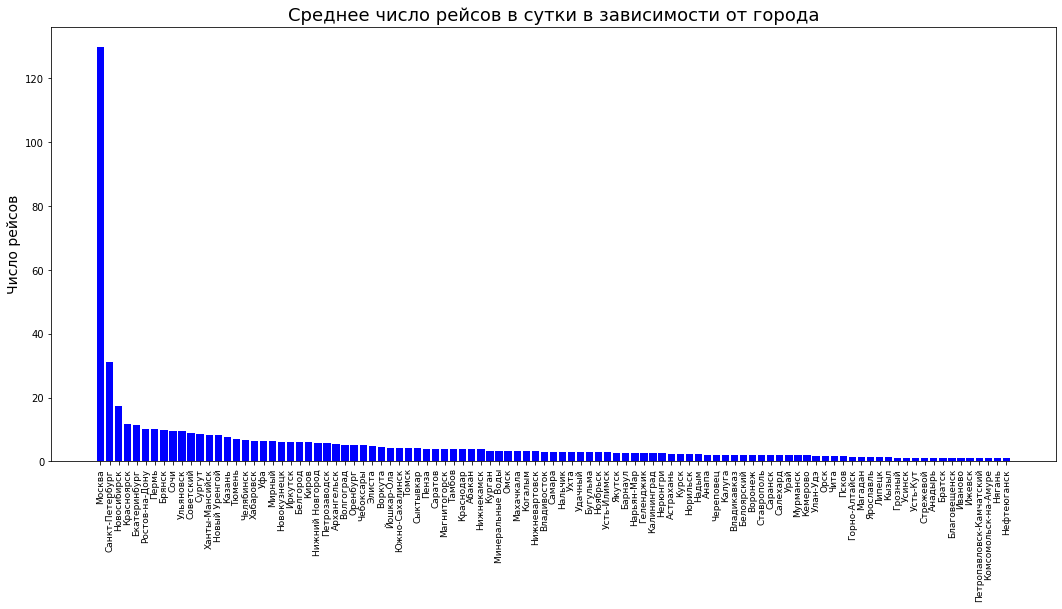

In [9]:
query_3 = query_3.sort_values(by = 'average_flights', ascending = False)

plt.figure(figsize = (18,8))
plt.bar(query_3['city'], query_3['average_flights'], color = 'blue')
plt.xticks(rotation=90, fontsize = '9')
plt.ylabel('Число рейсов', fontsize = '14')
plt.title('Среднее число рейсов в сутки в зависимости от города', fontsize = '18')
plt.show()

Я не совсем понимаю, зачем строить график для ТОП-10. Но пусть будет.

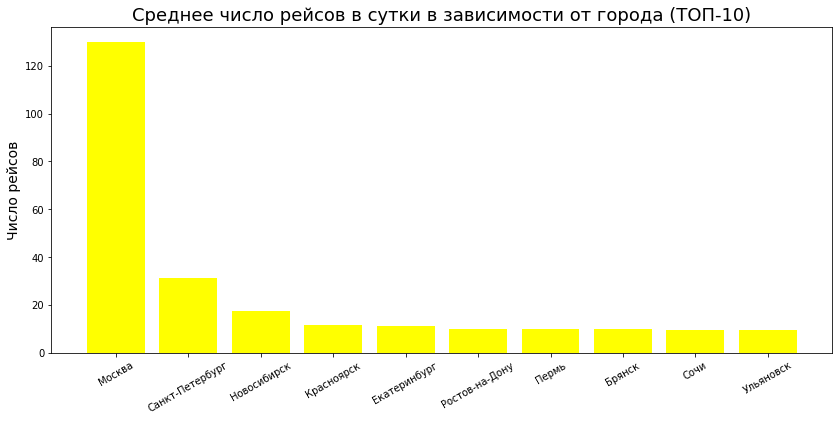

In [10]:
plt.figure(figsize = (14,6))
plt.bar(city_top_10_flights['city'], city_top_10_flights['average_flights'], color = 'yellow')
plt.xticks(rotation=30, fontsize = '10')
plt.ylabel('Число рейсов', fontsize = '14')
plt.title('Среднее число рейсов в сутки в зависимости от города (ТОП-10)', fontsize = '18')
plt.show()

## Выводы:

1. Москва - столица России (банально, но лучше не скажешь);
2. Города миллионники вместе с курортными центрами - сразу за Москвой. И это тоже "логично".

Переходим к проверке гипотезы!

# 2. Проверка гипотезы

In [11]:
query_last = pd.read_csv('/datasets/query_last.csv')
query_last

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Нам необходимо проверить гипотезу:

>«Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время»

Как мы знаем, мы не можем ПОДТВЕРДИТЬ гипотезу. Но мы можем её НЕ ОПРОВЕРГНУТЬ. Т.е. согласно имеющимся данным мы можем "не найти" противоречий в нулевой гипотезе и тем самым остановиться на ней. По крайней мере на какое-то время. 

Поскольку нам предстоит оперировать статистическими значениями генеральных совокупностей, нам будет необходимо РАЗДЕЛИТЬ имеющийся датасет (пусть в нем всего 10 значений) на 2 совокупности - недель, в которые БЫЛИ фестивали, и недель, в которые фестивалей не было. 

In [12]:
query_fill = query_last.fillna(999)
query_fill

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,999.0,999
3,33,51378,999.0,999
4,34,51492,999.0,999
5,35,51360,999.0,999
6,36,51386,36.0,Видфест
7,37,51670,999.0,999
8,38,51518,999.0,999
9,39,51623,999.0,999


In [13]:
fest_yes = query_fill[query_fill['festival_week'] != 999]
fest_yes

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
6,36,51386,36.0,Видфест


In [14]:
fest_no = query_fill[query_fill['festival_week'] == 999]
fest_no

,week_number,ticket_amount,festival_week,festival_name
2,32,51675,999.0,999
3,33,51378,999.0,999
4,34,51492,999.0,999
5,35,51360,999.0,999
7,37,51670,999.0,999
8,38,51518,999.0,999
9,39,51623,999.0,999


Итого, 7 значений в выборке без фестивалей, 3 значения - в выборке С фестивалем. Выглядит "маловато" - что бы это не значило :)

Но будем работать с тем, что есть. В перспективе, вероятно, стоило бы "разбить" данные до уровня дней - для более точного анализа происходящего - для "большей репрезентативности выборки". Хотя, вероятно, стоит научиться работать и с 10 значениями :D

Не всё ж нам большие данные пилить!

Сформулируем нулевую и альтернативную гипотезу.

И если нулевая гипотеза H0 звучит следующим образом:
> H0 = среднее генеральной совокупности "недель без фестивалей" равно среднему генеральной совокупности "недель с фестивалями"

Тогда альтернативная гипотеза H1 выглядит так:
> H1 = среднее генеральной совокупности "недель без фестивалей" НЕ равно среднему генеральной совокупности "недель с фестивалями"


Поскольку нас интересует РАВЕНСТВО (А не БОЛЬШЕ-МЕНЬШЕ), гипотеза - двухсторонняя. Доверительный интервал (уровень значимости) примем равным 5%. Нас интересует критерий Стьюдента.

Проверяем.

In [15]:
results_true = st.ttest_ind(fest_yes['ticket_amount'].values, fest_no['ticket_amount'].values, equal_var = True)

print('p-значение:', results_true.pvalue)

p-значение: 0.09688869045922928


In [16]:
results_false = st.ttest_ind(fest_yes['ticket_amount'].values, fest_no['ticket_amount'].values, equal_var = False)

print('p-значение:', results_false.pvalue)

p-значение: 0.377432493172683


Историю с дисперсией (СТД) не понимаю. Как она влияет на конечный результат? 

Получается, что в случае True - Дисперсия находится для СБОРНОГО датасета.
Во втором случае - для каждого по отдельности. 

В случае РАЗНОЙ дисперсии - вероятность СЛУЧАЙНОГО различия становится ещё выше. 

In [17]:
print('Дисперсия:', np.var(fest_yes['ticket_amount'].values), '/////', np.var(fest_no['ticket_amount'].values))

Дисперсия: 12998464.888888888 ///// 14694.408163265309


С вероятностью почти 10% различия в значениях сравниваемых выборок - случайны. Это почти в 2 раза выше уровня значимости. Следовательно, нулевую гипотезу нельзя отвергнуть. 

А значит фестивали, скорее всего не оказывают влияния на пассажиропоток в направлении Москвы. 

Или
>"Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время".